# SNAP demo : Sentinel-1 flood detection

## Importing libraries

In [1]:
import os
import sys
import time
from subprocess import Popen, PIPE, STDOUT
import glob
import shutil
from datetime import datetime
import numpy, matplotlib
!pip install rasterio
import rasterio
from rasterio.plot import show
#import getpass
#!pip install folium
#import folium

# Defining folder variables

In [2]:
os.environ["LD_LIBRARY_PATH"] = "."
HOME = os.getenv('HOME')
TMPDIR= os.getenv('TMPDIR')
if TMPDIR is None:
    TMPDIR=HOME+'/work'
    
now = datetime.now()
bar_message='######################################'
current_time=now.strftime("%Y%m%dT%H%M%S")
WORKDIR=os.getenv("WORKDIR")
if WORKDIR is None:
    workdir=TMPDIR
os.chdir(workdir)
os.environ["LD_LIBRARY_PATH"] = "."
outputpath=HOME

preproc_graphxml='/tmp/S1_Cal_ML_TC_template.xml'
flood_graphxml='/tmp/S1_flood_template.xml'
colorpalette='/tmp/wew_water_yel.cpd'
#graph2run=workdir+'/graph2run.xml'
outlog=workdir+'/s1_demo_stdout-'+current_time+'.log'
out_file = open(outlog, 'a')
GPT='/tmp/snap/bin/gpt'
CACHE='20G'
CPU='16'

# Input data for flood demo exercise

In [3]:
reference_image='/tmp/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED.zip'
flood_image='/tmp/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF.zip'

polygon='POLYGON ((95.91321563720703 23.948501586914062, 96.40089416503906 23.948501586914062, 96.40089416503906 23.406635284423828, 95.91321563720703 23.406635284423828, 95.91321563720703 23.948501586914062, 95.91321563720703 23.948501586914062))'
lonmin=95.91321563720703
latmin=23.406635284423828
lonmax=96.40089416503906
latmax=23.948501586914062

In [4]:
# If the user has downloaded another data, the variables reference_image and flood_image shall be re-defined
#reference_image="/tmp/"
#flood_image="/tmp/"

# Defining functions for graph xml creation and SNAP execution

In [5]:
def xml_S1_preproc(image,polygon):
    graphxml='/tmp/S1_Cal_ML_TC_template.xml'
    print(bar_message)
    out_file.write(bar_message+'\n')
    message=''
    print(message)
    out_file.write(message+'\n')
    name=os.path.basename(image[:-4])
    print(name)
    outputname=workdir+'/'+name
    message='Generating file:'
    print(message)
    out_file.write(message+'\n')
    print(outputname)
    out_file.write(outputname+'\n')
    with open(graphxml, 'r') as file :
        filedata = file.read()
    # Replace the target string
    filedata = filedata.replace('INPUTFILE', image)
    filedata = filedata.replace('OUTPUTFILE',outputname)
    filedata = filedata.replace('POLYGON',polygon)

    # # Write the file out again
    graph2run=workdir+'/graph2run'+name+'.xml'
    with open(graph2run, 'w') as file:
        file.write(filedata)

    ## Visualising graph to execute    
    print("############################")
    print("Visualising graph xml to execute")
    with open(graph2run, 'r') as fin:
        print(fin.read())
    return graph2run

In [6]:
def preproc_S1(image,graph2run):
    now = datetime.now()
    name=os.path.basename(image[:-4])
    ## Logging
    print(bar_message)
    out_file.write(bar_message+'\n')
    message='Launching S1 preproc of product: '+name
    print(message)
    out_file.write(message+'\n')
    current_time = now.strftime("%Y/%m/%d-%H:%M:%S")
    message='Time: '+current_time
    print(message)
    out_file.write(message+'\n')
    print(bar_message)
    #graph2run=workdir+'/graph2run'+name+'.xml'
    ## Executing SNAP with graph xml
    args = [ GPT, graph2run, '-c', CACHE, '-q', CPU]
    print(args)
    out_file.write(str(args)+'\n')
    # launching the process
    timeStarted = time.time()
    process = Popen(args, stdout=PIPE, stderr=STDOUT)
    r = b""
    for line in process.stdout:
        r += line
        print(str(line))
        out_file.write(str(line)+'\n')
    process.wait()
    timeDelta = time.time() - timeStarted     # Get execution time.
    print('Finished process in '+str(timeDelta)+' seconds.')
    out_file.write('Finished process in '+str(timeDelta)+' seconds.\n')
    if process.returncode != 0 :
        message='Error preprocessing S1 image'
        out_file.write(message)
    else: 
        message='Preprocessing of S1 image successfully completed.'
        print( message)
        print(bar_message)
        out_file.write(message+'\n')
        source=name+'.tif'
        destination=outputpath+'/'+os.path.basename(name)+'.tif'
    print(bar_message)
    out_file.write(bar_message+'\n')
    now = datetime.now()
    current_time = now.strftime("%Y/%m/%d-%H:%M:%S")
    message='Time: '+current_time
    print(message)
    out_file.write(message+'\n')
    print(bar_message)

In [7]:
def flood_graph(reference,flood,thr_ref,thr_flood):
    graphxml='/tmp/S1_flood_template.xml'
    bar_message="#######################"
    print(bar_message)
    out_file.write(bar_message+'\n')
    message=''
    print(message)
    out_file.write(message+'\n')
    name=os.path.basename(flood[:-4])
    print(name)
    outputname=workdir+'/'+name+'_flood_mask'
    message='Generating file:'
    print(message)
    out_file.write(message+'\n')
    print(outputname)
    out_file.write(outputname+'\n')
    with open(graphxml, 'r') as file :
        filedata = file.read()
    # Replace the target string
    filedata = filedata.replace('REFERENCE_IMAGE', reference)
    filedata = filedata.replace('FLOOD_IMAGE',flood)
    filedata = filedata.replace('REFERENCE_BAND','Sigma0_VV_db_mst_04Jul2019')
    filedata = filedata.replace('FLOOD_BAND','Sigma0_VV_db_slv1_16Jul2019')
    filedata = filedata.replace('thr_ref',str(thr_ref))
    filedata = filedata.replace('thr_flood',str(thr_flood))
    filedata = filedata.replace('FLOOD_MASK',outputname)

    # # Write the file out again
    graph2run=workdir+'/graph2run_flood.xml'
    with open(graph2run, 'w') as file:
        file.write(filedata)

    ## Visualising graph to execute    
    print("############################")
    print("Visualising graph xml to execute")
    with open(graph2run, 'r') as fin:
        print(fin.read())
    return graph2run

In [8]:
def flood_detection(graph2run):
    ## Logging
    now = datetime.now()
    bar_message="#######################"
    print(bar_message)
    out_file.write(bar_message+'\n')
    message='Starting the flood detection using BandMath:'
    print(message)
    out_file.write(message+'\n')
    current_time = now.strftime("%Y/%m/%d-%H:%M:%S")
    message='Time: '+current_time
    print(message)
    out_file.write(message+'\n')
    print(bar_message)
    graph2run=workdir+'/graph2run_flood.xml'
    ## Executing SNAP with graph xml
    args = [ GPT, graph2run, '-c', CACHE, '-q', CPU]
    print(args)
    out_file.write(str(args)+'\n')
    # launching the process
    timeStarted = time.time()
    process = Popen(args, stdout=PIPE, stderr=STDOUT)
    r = b""
    for line in process.stdout:
        r += line
        print(str(line))
        out_file.write(str(line)+'\n')
    process.wait()
    timeDelta = time.time() - timeStarted     # Get execution time.
    print('Finished process in '+str(timeDelta)+' seconds.')
    out_file.write('Finished process in '+str(timeDelta)+' seconds.\n')
    if process.returncode != 0 :
        message='Error in the flood detection processing'
        out_file.write(message)
    else: 
        message='Flood detection processing successfully completed.'
        print( message)
        print(bar_message)
        out_file.write(message+'\n')
        #outputname=workdir+'/'+name+'_flood_mask'
        #source=outputname+'.tif'
        #destination=outputpath+'/'+os.path.basename(outputname)+'.tif'
    print(bar_message)
    out_file.write(bar_message+'\n')
    now = datetime.now()
    current_time = now.strftime("%Y/%m/%d-%H:%M:%S")
    message='Time: '+current_time
    print(message)
    out_file.write(message+'\n')
    print(bar_message)

# Launching preprocessing of the selected Sentinel-1 products

In [9]:
files=[reference_image,flood_image]
polygon='POLYGON (('+str(lonmin)+' '+str(latmin)+','+str(lonmax)+' '+str(latmin)+','+str(lonmax)+' '+str(latmax)+','+str(lonmin)+' '+str(latmax)+','+str(lonmin)+' '+str(latmin)+'))'
for sentinelfile in files:
    print(bar_message)
    out_file.write(bar_message+'\n')
    message=''
    print(message)
    out_file.write(message+'\n')
    
    # Create xml to execute
    graph2run=xml_S1_preproc(sentinelfile,polygon)
    # Running SNAP with the created graph xml
    preproc_S1(sentinelfile,graph2run)

######################################

######################################

S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED
Generating file:
/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED
############################
Visualising graph xml to execute
<graph id="Graph">
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <file>/tmp/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED.zip</file>
    </parameters>
  </node>
  <node id="Subset">
    <operator>Subset</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <sourceBands>Amplitude_VV</sourceBands>
      <region>0,0,0,0</region>
      <referenceBand/>
      <geoRegion>POLYGON ((95.91321563720703 23.406635284423828,96.40089416503906 23.406635284423828,96.40089

# Histogram visualisation of the pre-processed Sentinel-1 images

### Reference image

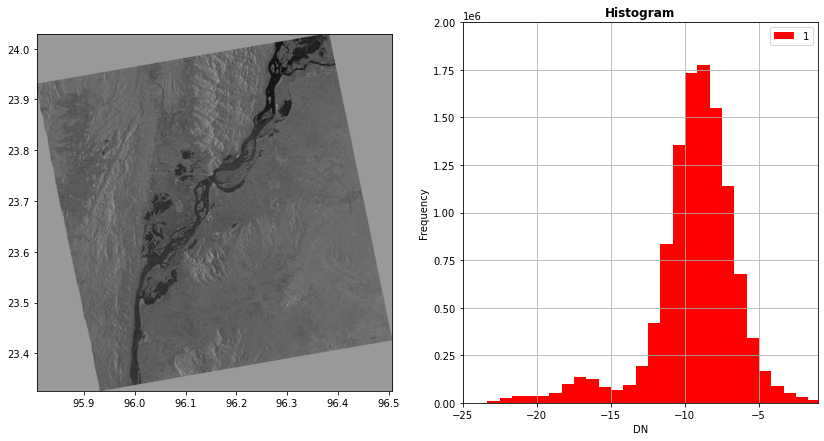

In [10]:
!pip install rasterio
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

workdir='/home/jovyan/work/'
reference=glob.glob(workdir+'/'+os.path.basename(reference_image[:-4])+'*.tif')[0]

with rasterio.open(reference) as src:
    band=src.read(1)
    #show_hist(band, bins=100, masked=True, title='Histogram', ax=None, label=None)
    #show(band,cmap='gray')
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb,cmap='gray')
    show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
    axhist.set(xlim=(-25, -1), ylim=(0, 2e6))
    pyplot.show()

### Flooded image

In [11]:
!pip install rasterio
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

workdir='/home/jovyan/work/'
flooded=glob.glob(workdir+'/'+os.path.basename(flood_image[:-4])+'*.tif')[0]

with rasterio.open(flooded) as src:
    band=src.read(1)
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb,cmap='gray')
    show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
    axhist.set(xlim=(-25, -1), ylim=(0, 2e6))
    pyplot.show()

# Flood detection using the SNAP Math band 
## Computing flood mask using user defined thresholds

In [12]:
import glob
import os
workdir='/home/jovyan/work'
reference=glob.glob(workdir+'/'+os.path.basename(reference_image[:-4])+'*.tif')[0]
flooded=glob.glob(workdir+'/'+os.path.basename(flood_image[:-4])+'*.tif')[0]
print(reference)
print(flooded)
#flood_graph(reference,flooded,thr_reference,thr_flooded)
graphxml=flood_graph(reference,flooded,-14,-15)
flood_detection(graphxml)

/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.tif
/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC.tif
#######################

S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC
Generating file:
/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC_flood_mask
############################
Visualising graph xml to execute
<graph id="Graph">
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <file>/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.tif</file>
    </parameters>
  </node>
  <node id="Read(2)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <file>/home/jovyan/w

# Create quicklook visualisation of results

## function definition of quicklook generation


In [13]:
# function definition of quicklook generation
from datetime import datetime
import time
from subprocess import Popen,PIPE,STDOUT

def quicklook_gen(image): #,colormap):
    now = datetime.now()
    tmpfolder='/home/jovyan/work'
    if 'mask' in image:
        cmd=['/tmp/snap/bin/pconvert','-b','1','-c','/tmp/wew_water_yel.cpd',image,'-f','png','-o',tmpfolder]
    else:
        cmd=['/tmp/snap/bin/pconvert','-b','1',image,'-f','png','-o',tmpfolder]
    print('#########################')
    print('Creating browse image')
    timeStarted = time.time()
    process = Popen(cmd, stdout=PIPE, stderr=STDOUT)
    r = b""
    for line in process.stdout:
        r += line
        print(str(line))
    process.wait()
    timeDelta = time.time() - timeStarted                     # Get execution time.
    print('Finished process in '+str(timeDelta)+' seconds.')
    if process.returncode != 0 :
        message='Error creating browse image'
    else:
        message='Browse image successfully completed.'
        print( message)



## Creating quicklooks

In [15]:
# Creating quicklook for results
mask=glob.glob('/home/jovyan/work/*_flood_mask.tif')[0]
images=[reference,flooded,mask]
print(images)
for file in images:
    print('Generating quicklook of file:'+file)
    quicklook_gen(file)#,None)

['/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.tif', '/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC.tif', '/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC_flood_mask.tif']
/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.tif
#########################
Creating browse image
b'INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters\n'
b'INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.\n'
b'reading file /home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.tif\n'
b'INFO: org.hsqldb.persist.Logger: dataFileCache open start\n'
b"creating histogram for band 'Sigma0_VV_db'...\n"
b'creating RGB image...\n'

## Showing quicklook images

['/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.png', '/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC.png', '/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC_flood_mask.png']
/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_dB_ML_TC.png


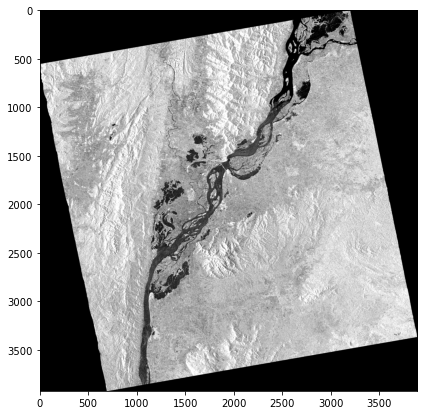

/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC.png


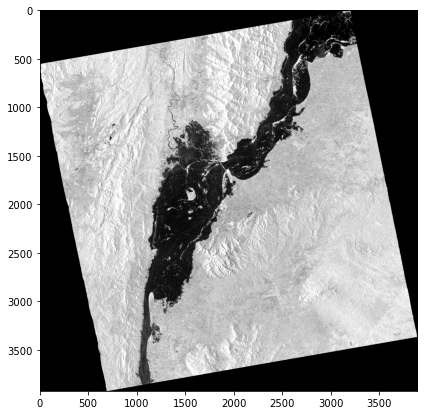

/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_dB_ML_TC_flood_mask.png


In [5]:
!pip install rasterio
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os


workdir='/home/jovyan/work/'
images=sorted(glob.glob(os.path.join(workdir,'*png')))
print(images)

#fig, (axref, axflood, axmask) = pyplot.subplots(1, 3, figsize=(14,7))
for file in images:        
    print(file)
    with rasterio.open(file) as src:
        fig, ax = pyplot.subplots(figsize=(14,7))
        show(src)
        #pyplot.show()